# Problem Statement:

We want to build a CNN to accurately classifiy CIFAR-10 dataset(dataset containing labels and image for airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.) in an efficient way.
The traiditonal training CNN model for CIFAR-10 will take huge computation hours and is not scalable for certain use cases.
We want to take a different approach to save the training time and also obtain high testing accuracy.
As a result, we found out transfer learning could be useful in this case since we only need to first find a more generic pretrained model and then add and train one additional loss layer to create a new CNN model with less data and still high accuracy.

# Method:

1)we trained the recommended AlexNet model for cifar-10 dataset from tensorflow. It took 18 hours of trainning and we only obtain 0.86 precision

2)
Instead, we took the pretained inception-3 model and add an extra fully connected loss layer at the end to train cifar-10 dataset.

First we compute the transfer values(the values of the layer before applied softmax)for the inception model. Then we add another fully connected layer to the network and train the weights of the new layer with cifar-10 dataset.

We have tried 5 different optimizer for the lost layer to compare the peformance of each optimizer. To train the last layer, It took only average 5 minutes per optimizer, which is a significant improvement compared to the alexnet model.

Some of our implementation are done through the tutorial done by by Magnus Erik Hvass Pedersen, and we made couple of changes to make the demo more interesting. 

## Flowchart

We did some research and the work done by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/) inspired and helped us take the transfer leanring approch. We reference some of his work and here the basic idea for this approach.

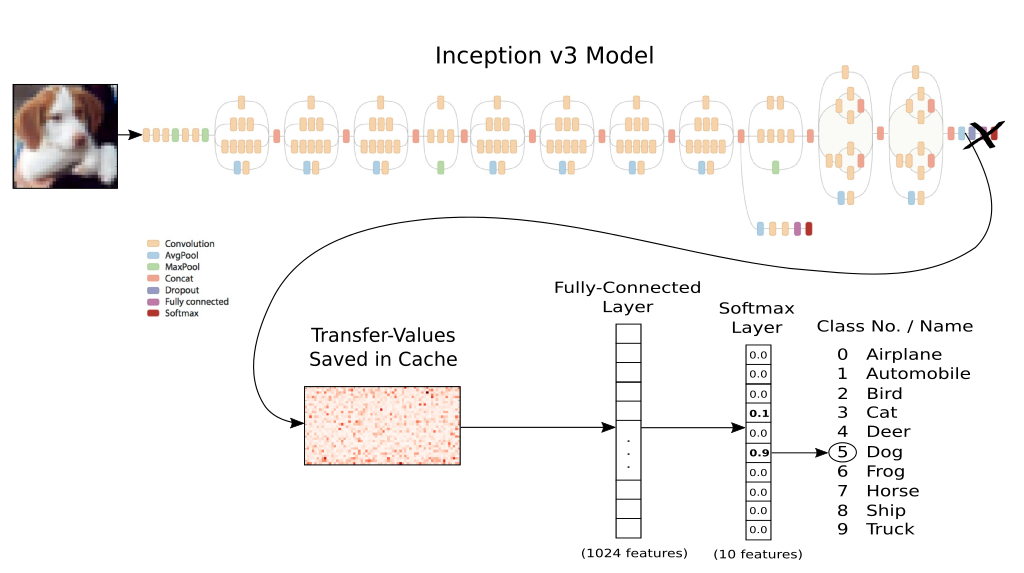

In [1]:
from IPython.display import Image, display
Image('images/08_transfer_learning_flowchart.png')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import os

# Functions and classes for loading and using the Inception model.
import inception

# We use Pretty Tensor to define the new classifier.
import prettytensor as pt

## Load CIFAR-10 data

In [3]:
import cifar10
from cifar10 import num_classes
# cifar10.data_path = "data/CIFAR-10/"
cifar10.maybe_download_and_extract()
class_names = cifar10.load_class_names()
#Load the training-set, including the image and label
images_train, cls_train, labels_train = cifar10.load_training_data()
#Load the test-set.
images_test, cls_test, labels_test = cifar10.load_test_data()

Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


## Initialize the inception model

In [4]:
# inception.data_dir = 'inception/'
inception.maybe_download()
inception_model = inception.Inception()

Data has apparently already been downloaded and unpacked.


## Calculate previous activation value and cache them

In [5]:
from inception import transfer_values_cache
file_path_cache_train = os.path.join(cifar10.data_path, 'inception_cifar10_train.pkl')
file_path_cache_test = os.path.join(cifar10.data_path, 'inception_cifar10_test.pkl')

In [6]:
print("Calculating activation results ...")

# Rescale images because inception model require pixels to be 0-255
# The CIFAR-10 return pixels from 0 to 1
images_scaled = images_train * 255.0

# calculate transfer values or load from cache
transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              images=images_scaled,
                                              model=inception_model)

Calculating activation results ...
- Data loaded from cache-file: data/CIFAR-10/inception_cifar10_train.pkl


In [7]:
#Same process for the test dataset
print("Calculating activation results for test set...")
images_scaled = images_test * 255.0
transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             images=images_scaled,
                                             model=inception_model)

Calculating activation results for test set...
- Data loaded from cache-file: data/CIFAR-10/inception_cifar10_test.pkl


Sanity check for training dataset

In [8]:
transfer_values_train.shape

(50000, 2048)

Sanity check for testing dataset

In [9]:
transfer_values_test.shape

(10000, 2048)

## Building our last layer using Tensorflow

### Variable initialization

In [10]:
x = tf.placeholder(tf.float32, shape=[None, inception_model.transfer_len], name='x')
y_true_value = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_label = tf.argmax(y_true_value, dimension=1)

### Add the last layer

In [11]:
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = pt.wrap(x)\
    .fully_connected(size=1024, name='last_fc_layer')\
    .softmax_classifier(num_classes=num_classes, labels=y_true_value)

### Optimization Method

Create a variable for keeping track of the number of optimization iterations performed.

In [12]:
global_step = tf.Variable(initial_value=0,name='global_step', trainable=False)

We decide to try a few optimizer for our last layer and compare their performance

## justification on different optimizers

momentumOptimizer_no_nesterov:
    With mementum, SGD can avoid local minimum and saddle point because of the added velocity and mementum term for weight updates. The added terms will correlate the current gradient to the previous graident so that gradient won't stuck at zero in local minimum and saddle point. It allows gradient to change fast in relevant directions and slow in irrelation direction. However, one problem for this optimizer is that when we get close to the optimal, the momentum is still very high and it will oscillate around the optimal.
    
momentumOptimizer_nesterov:
    nesterov accelerated gradient solves the problem of osciilating around the optimal by taking the opposite approach updating the weight. It first update the weight according to the previous update and then take the gradient of current update and make small correction. This will give speedups to avoid osccilation.

adagrad_optimizer:
    applies adaptive learning rate based on parameters. I update fast for in frequent parameters and slow on frequent parameters. It favor sparse data like the image data. However, the learning rate is monotonically decreasing and it will cause really slow learnig close to the optimal.
    
adadelta_optimizer:
    AdaDekta solve the monotonically decreasing learning rate from adagrad optimizer. The learning rate is calculated as one over the sum of square root and uses sliding window to allow sum to decrease so that the learning rate is not always decreasing.
    
adam_optimizer:
    It is similar to adadelta but in addtion it also uses momentum.


In [13]:
adam_optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step)
adadelta_optimizer = tf.train.AdadeltaOptimizer(learning_rate=1e-4).minimize(loss, global_step)
adagrad_optimizer = tf.train.AdagradOptimizer(learning_rate=1e-4).minimize(loss, global_step)
momentumOptimizer_nesterov = tf.train.MomentumOptimizer(learning_rate=1e-4, momentum=0.01, use_nesterov=True).minimize(loss, global_step)      
momentumOptimizer_no_nesterov = tf.train.MomentumOptimizer(learning_rate=1e-4, momentum=0.01, use_nesterov=False).minimize(loss, global_step)                                                                

### Calculating error

The output of the network `y_pred` is an array with 10 elements. The class number is the index of the largest element in the array.

In [14]:
y_pred_cls = tf.argmax(y_pred, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_label)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Running our created layer

In [15]:
session = tf.Session()
session.run(tf.global_variables_initializer())

### Helper-function to get a random training-batch

In [16]:
train_batch_size = 64

Function for selecting a random batch of transfer-values from the training-set.

In [17]:
def random_batch():
    # get a random index.
    idx = np.random.choice(len(transfer_values_train),
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random x and y-values.
    # We use the transfer-values instead of images as x-values.
    x_batch = transfer_values_train[idx]
    y_batch = labels_train[idx]

    return x_batch, y_batch

### Helper-function to perform optimization

This fumction use a optimizer to take weight updates for the last layer using batch gradient descent

In [18]:
def optimize(iterations, optimizer):
    start_time = time.time()

    for i in range(iterations):
        # Get a batch of training examples.
        x_batch, y_true_batch = random_batch()

        # feed batch into the tensor graph
        feed_dict_train = {x: x_batch, y_true_value: y_true_batch}

        # start training to update the weight at the last layer wrt the optimizer
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Print status to screen every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_accurarcy = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # Print status.
            msg = "Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_accurarcy))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

## Helper-Functions for Showing Results

### Helper-function to plot example errors

In [19]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = images_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]

    n = min(9, len(images))
    
    # Plot the first n images.
    plot_images(images=images[0:n],
                cls_true=cls_true[0:n],
                cls_pred=cls_pred[0:n])

### Helper-function for plotting images

In [20]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function to plot confusion matrix

In [21]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

### Helper-functions for calculating classifications

In [22]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(transfer_values, labels, cls_true):
    # Number of images.
    num_images = len(transfer_values)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: transfer_values[i:j],y_true_value: labels[i:j]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j
        
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

Calculate the predicted class for the test-set.

In [23]:
def predict_cls_test():
    return predict_cls(transfer_values = transfer_values_test,
                       labels = labels_test,
                       cls_true = cls_test)

### Helper-functions for calculating the classification accuracy

In [24]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.

    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

### Helper-function for showing the classification accuracy

In [25]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Results

## Performance before any optimization

The classification accuracy on the test-set is very low because the model variables have only been initialized and not optimized at all, so it just classifies the images randomly.

In [26]:
print_test_accuracy(show_example_errors=False,
                    show_confusion_matrix=False)

Accuracy on Test-Set: 5.9% (591 / 10000)


## Performance after 10,000 optimization iterations

Step:    100, Training Batch Accuracy:  82.8%
Step:    200, Training Batch Accuracy:  89.1%
Step:    300, Training Batch Accuracy:  84.4%
Step:    400, Training Batch Accuracy:  93.8%
Step:    500, Training Batch Accuracy:  90.6%
Step:    600, Training Batch Accuracy:  90.6%
Step:    700, Training Batch Accuracy:  87.5%
Step:    800, Training Batch Accuracy:  82.8%
Step:    900, Training Batch Accuracy:  92.2%
Step:   1000, Training Batch Accuracy:  93.8%
Step:   1100, Training Batch Accuracy:  92.2%
Step:   1200, Training Batch Accuracy:  93.8%
Step:   1300, Training Batch Accuracy:  90.6%
Step:   1400, Training Batch Accuracy:  82.8%
Step:   1500, Training Batch Accuracy:  85.9%
Step:   1600, Training Batch Accuracy:  90.6%
Step:   1700, Training Batch Accuracy:  89.1%
Step:   1800, Training Batch Accuracy:  89.1%
Step:   1900, Training Batch Accuracy:  89.1%
Step:   2000, Training Batch Accuracy:  84.4%
Step:   2100, Training Batch Accuracy:  93.8%
Step:   2200, Training Batch Accur

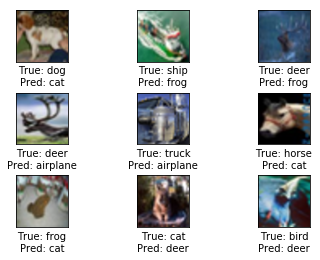

Confusion Matrix:
[918   9  11   6   7   0   1   2  41   5] (0) airplane
[  4 971   1   4   0   1   3   1   6   9] (1) automobile
[ 18   0 893  23  25   9  22   6   2   2] (2) bird
[  3   3  19 852  21  66  17  15   4   0] (3) cat
[  7   0  23  22 888   8  18  31   2   1] (4) deer
[  3   0   8  79  18 869   5  17   1   0] (5) dog
[  4   1  21  21  21   4 923   2   3   0] (6) frog
[  7   0  10  21  19  16   1 922   2   2] (7) horse
[ 30   5   1   3   1   1   1   0 955   3] (8) ship
[ 14  82   3   4   1   1   1   1  13 880] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [27]:
optimize(10000, adam_optimizer)
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

Step:  10100, Training Batch Accuracy: 100.0%
Step:  10200, Training Batch Accuracy:  98.4%
Step:  10300, Training Batch Accuracy:  96.9%
Step:  10400, Training Batch Accuracy: 100.0%
Step:  10500, Training Batch Accuracy:  93.8%
Step:  10600, Training Batch Accuracy:  98.4%
Step:  10700, Training Batch Accuracy:  98.4%
Step:  10800, Training Batch Accuracy:  95.3%
Step:  10900, Training Batch Accuracy: 100.0%
Step:  11000, Training Batch Accuracy:  98.4%
Step:  11100, Training Batch Accuracy:  98.4%
Step:  11200, Training Batch Accuracy:  96.9%
Step:  11300, Training Batch Accuracy: 100.0%
Step:  11400, Training Batch Accuracy: 100.0%
Step:  11500, Training Batch Accuracy:  95.3%
Step:  11600, Training Batch Accuracy:  96.9%
Step:  11700, Training Batch Accuracy: 100.0%
Step:  11800, Training Batch Accuracy:  98.4%
Step:  11900, Training Batch Accuracy:  98.4%
Step:  12000, Training Batch Accuracy:  95.3%
Step:  12100, Training Batch Accuracy: 100.0%
Step:  12200, Training Batch Accur

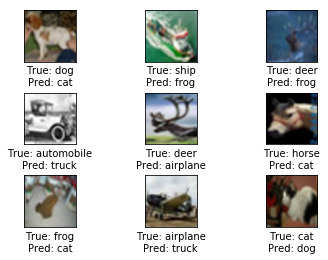

Confusion Matrix:
[910   7  13   5   9   0   1   1  38  16] (0) airplane
[  5 950   1   4   0   2   3   1   7  27] (1) automobile
[ 14   0 894  23  27  11  23   5   1   2] (2) bird
[  3   1  14 837  19  86  21  13   4   2] (3) cat
[  5   0  21  23 889  10  19  30   2   1] (4) deer
[  2   0   8  66  17 885   7  14   1   0] (5) dog
[  3   0  17  17  16   4 939   2   2   0] (6) frog
[  6   0  10  19  22  22   2 915   1   3] (7) horse
[ 30   4   0   3   1   2   1   0 954   5] (8) ship
[  6  37   2   0   1   1   2   1  11 939] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [28]:
optimize(10000, adagrad_optimizer)
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

Step:  20100, Training Batch Accuracy: 100.0%
Step:  20200, Training Batch Accuracy: 100.0%
Step:  20300, Training Batch Accuracy:  98.4%
Step:  20400, Training Batch Accuracy:  98.4%
Step:  20500, Training Batch Accuracy: 100.0%
Step:  20600, Training Batch Accuracy:  96.9%
Step:  20700, Training Batch Accuracy:  96.9%
Step:  20800, Training Batch Accuracy: 100.0%
Step:  20900, Training Batch Accuracy:  98.4%
Step:  21000, Training Batch Accuracy:  98.4%
Step:  21100, Training Batch Accuracy:  98.4%
Step:  21200, Training Batch Accuracy: 100.0%
Step:  21300, Training Batch Accuracy:  96.9%
Step:  21400, Training Batch Accuracy:  98.4%
Step:  21500, Training Batch Accuracy:  95.3%
Step:  21600, Training Batch Accuracy:  98.4%
Step:  21700, Training Batch Accuracy:  98.4%
Step:  21800, Training Batch Accuracy:  96.9%
Step:  21900, Training Batch Accuracy: 100.0%
Step:  22000, Training Batch Accuracy:  95.3%
Step:  22100, Training Batch Accuracy:  98.4%
Step:  22200, Training Batch Accur

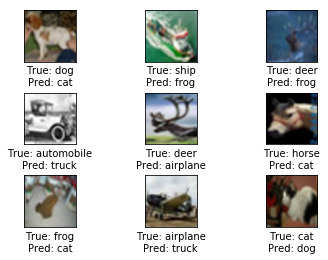

Confusion Matrix:
[910   7  13   5   9   0   1   1  38  16] (0) airplane
[  5 950   1   4   0   2   3   1   7  27] (1) automobile
[ 14   0 894  23  27  11  23   5   1   2] (2) bird
[  3   1  14 841  19  81  21  14   4   2] (3) cat
[  5   0  21  23 891   8  19  30   2   1] (4) deer
[  2   0   8  68  17 882   7  15   1   0] (5) dog
[  3   0  17  17  16   4 939   2   2   0] (6) frog
[  6   0  10  19  22  21   2 916   1   3] (7) horse
[ 30   4   0   3   1   2   1   0 954   5] (8) ship
[  6  37   2   0   1   1   2   1  11 939] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [29]:
optimize(10000, adadelta_optimizer)
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

Step:  30100, Training Batch Accuracy: 100.0%
Step:  30200, Training Batch Accuracy:  96.9%
Step:  30300, Training Batch Accuracy: 100.0%
Step:  30400, Training Batch Accuracy:  98.4%
Step:  30500, Training Batch Accuracy: 100.0%
Step:  30600, Training Batch Accuracy:  98.4%
Step:  30700, Training Batch Accuracy:  96.9%
Step:  30800, Training Batch Accuracy:  96.9%
Step:  30900, Training Batch Accuracy:  98.4%
Step:  31000, Training Batch Accuracy:  98.4%
Step:  31100, Training Batch Accuracy:  96.9%
Step:  31200, Training Batch Accuracy: 100.0%
Step:  31300, Training Batch Accuracy: 100.0%
Step:  31400, Training Batch Accuracy:  98.4%
Step:  31500, Training Batch Accuracy:  95.3%
Step:  31600, Training Batch Accuracy:  98.4%
Step:  31700, Training Batch Accuracy:  96.9%
Step:  31800, Training Batch Accuracy: 100.0%
Step:  31900, Training Batch Accuracy:  96.9%
Step:  32000, Training Batch Accuracy:  96.9%
Step:  32100, Training Batch Accuracy:  98.4%
Step:  32200, Training Batch Accur

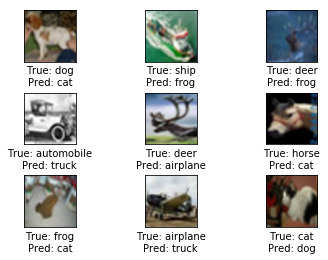

Confusion Matrix:
[910   7  13   5   9   0   1   1  38  16] (0) airplane
[  5 950   1   4   0   2   3   1   7  27] (1) automobile
[ 14   0 894  23  27  11  23   5   1   2] (2) bird
[  3   1  14 838  20  82  21  15   4   2] (3) cat
[  4   0  21  23 892   8  20  29   2   1] (4) deer
[  2   0   9  67  16 881   7  17   1   0] (5) dog
[  3   0  17  17  16   4 939   2   2   0] (6) frog
[  6   0  10  18  22  21   2 917   1   3] (7) horse
[ 30   4   0   3   1   2   1   0 954   5] (8) ship
[  6  35   2   0   1   1   2   1  11 941] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [30]:
optimize(10000, momentumOptimizer_nesterov)
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

Step:  40100, Training Batch Accuracy:  96.9%
Step:  40200, Training Batch Accuracy:  96.9%
Step:  40300, Training Batch Accuracy: 100.0%
Step:  40400, Training Batch Accuracy:  93.8%
Step:  40500, Training Batch Accuracy: 100.0%
Step:  40600, Training Batch Accuracy:  95.3%
Step:  40700, Training Batch Accuracy: 100.0%
Step:  40800, Training Batch Accuracy:  98.4%
Step:  40900, Training Batch Accuracy:  93.8%
Step:  41000, Training Batch Accuracy:  96.9%
Step:  41100, Training Batch Accuracy:  98.4%
Step:  41200, Training Batch Accuracy:  98.4%
Step:  41300, Training Batch Accuracy:  96.9%
Step:  41400, Training Batch Accuracy: 100.0%
Step:  41500, Training Batch Accuracy: 100.0%
Step:  41600, Training Batch Accuracy: 100.0%
Step:  41700, Training Batch Accuracy: 100.0%
Step:  41800, Training Batch Accuracy:  98.4%
Step:  41900, Training Batch Accuracy:  98.4%
Step:  42000, Training Batch Accuracy:  98.4%
Step:  42100, Training Batch Accuracy:  96.9%
Step:  42200, Training Batch Accur

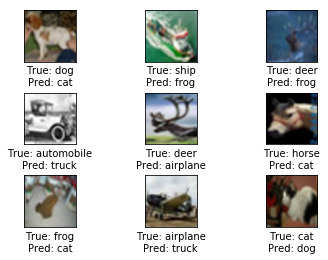

Confusion Matrix:
[911   7  13   4   9   1   1   1  37  16] (0) airplane
[  5 951   1   4   0   2   3   1   6  27] (1) automobile
[ 14   0 895  23  27  11  22   5   1   2] (2) bird
[  3   1  14 838  19  85  20  14   4   2] (3) cat
[  5   0  22  22 892   8  19  29   2   1] (4) deer
[  2   0   9  66  16 885   7  14   1   0] (5) dog
[  3   0  17  17  16   4 939   2   2   0] (6) frog
[  6   0  10  18  22  22   2 916   1   3] (7) horse
[ 30   4   0   3   1   2   1   0 954   5] (8) ship
[  6  37   2   0   1   1   2   1  11 939] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [31]:
optimize(10000, momentumOptimizer_no_nesterov)
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## Close TensorFlow Session

In [32]:
# model.close()
# session.close()

## Conclusion

Each Optimzation takes about 5 to 6 minutes and the total training time is about a few hours.

Although there is no significant different among 5 optimizer we do observe SGD with momentum offers better accuracy and fast training time. 

Over all through transfer learning, we are able to achieve better performance 91% accuracy verses 86% with less trainning time. We use pretainined inception3 model trainned on more generic image data then we train the model with one more loss layer with cifar-10 dataset. The end result produce better performance.
